**Challenge:** Apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment 

In [0]:
#Loading basic packages

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Making the text prepocessing easy with fastai package. As the library simplifies training the data quickly

import fastai

# The DataBunch module of fastai posses all the functions to convert the text statements sutiable for NLP and helps in creating the models quickly and efficiently

from fastai.text import *
from google.colab import files

#Used for splitting the data for training and testing the model
from sklearn.model_selection import train_test_split
import string


In [0]:
#Downloading the Tweets data for analysis
files.upload()

{}

In [0]:
#Reading the file for twitter sentiment analysis and showing the content of csv file
df = pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
print("Number of entries in the Tweets dataset: ",len(df))
print("Shape of the Tweets dataset: ",df.shape)

Number of entries in the Tweets dataset:  14640
Shape of the Tweets dataset:  (14640, 15)


This challenge will basically help us in getting answers of the two questions shown below:


*   Can ULMFiT really perform well on small datasets?

*  How well can knowledge be transferred from a source domain that is quite different to the target domain?

This problem of implementing ULMFiT model is to help us understand the importance of Transfer Learning.The biggest challenge in deep learning is having huge data requirements for training the models but, sometimes the data is not sufficient for training the model and also high computing required for the execution of these algortihms. This is where Transfer Learning comes into picture where we have a pretrained model on complex dataset and we just need to fine tune the model according to our dataset to get efficient results.

As the ULMFiT Model is pretrained on Wikitext-103 dataset containing 28,595 preprocessed English articles and 103 million words, we will for this challenge just need to fine tune the parameters for the model to get great accuracy on our twitter data which consists of only 14,640 entries. The analysis will help us answer the two questions



**Data Visualizations and Exploration**

In [0]:
df.describe(include='all')

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,1.464000e+04,14640,14640.000000,9178,10522.000000,14640,40,14640,32,14640.000000,14640,1019,14640,9907,9820
unique,NaN,3,NaN,10,NaN,6,3,7701,13,NaN,14427,832,14247,3081,85
top,NaN,negative,NaN,Customer Service Issue,NaN,United,negative,JetBlueNews,Customer Service Issue,NaN,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,NaN,9178,NaN,2910,NaN,3822,32,63,12,NaN,6,164,5,157,3744
mean,5.692184e+17,NaN,0.900169,NaN,0.638298,NaN,NaN,NaN,NaN,0.082650,NaN,NaN,NaN,NaN,NaN
std,7.791112e+14,NaN,0.162830,NaN,0.330440,NaN,NaN,NaN,NaN,0.745778,NaN,NaN,NaN,NaN,NaN
min,5.675883e+17,NaN,0.335000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,5.685592e+17,NaN,0.692300,NaN,0.360600,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
50%,5.694779e+17,NaN,1.000000,NaN,0.670600,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
75%,5.698905e+17,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Count the null entries in particular columns of data
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


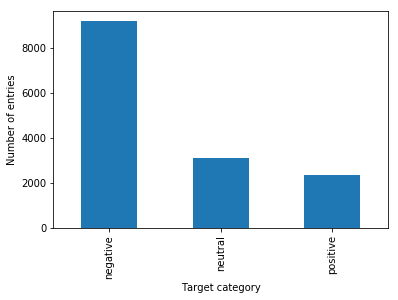

In [0]:
#Understand how many entries are in each category of target variable
sentimentcount=df.airline_sentiment.value_counts()
print(sentimentcount)
sentimentcount.plot(kind='bar')
plt.xlabel("Target category")
plt.ylabel("Number of entries")
plt.show()


Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


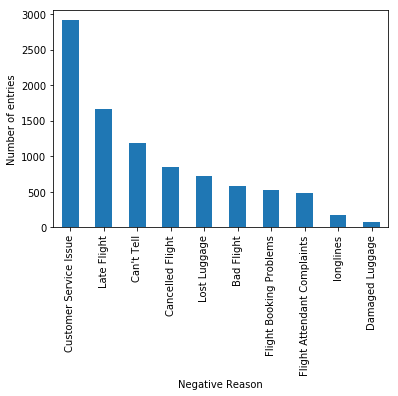

In [0]:
#know the negative reasons count
nr=df.negativereason.value_counts()
print(nr)
nr.plot(kind='bar')
plt.xlabel("Negative Reason")
plt.ylabel("Number of entries")
plt.show()

In [0]:
#To know relation between negative reason and particular flight
df1 = df.groupby(['negativereason','airline'])
df1 = df1.airline_sentiment.value_counts()
df1.unstack()

airline_sentiment                           negative
negativereason              airline                 
Bad Flight                  American              87
                            Delta                 64
                            Southwest             90
                            US Airways           104
                            United               216
                            Virgin America        19
Can't Tell                  American             198
                            Delta                186
                            Southwest            159
                            US Airways           246
                            United               379
                            Virgin America        22
Cancelled Flight            American             246
                            Delta                 51
                            Southwest            162
                            US Airways           189
                            United               181
                            Virgin America        18
Customer Service Issue      American             768
                            Delta                199
                            Southwest            391
                            US Airways           811
                            United               681
                            Virgin America        60
Damaged Luggage             American              12
                            Delta                 11
                            Southwest             14
                            US Airways            11
                            United                22
                            Virgin America         4
Flight Attendant Complaints American              87
                            Delta                 60
                            Southwest             38
                            US Airways           123
                            United               168
                            Virgin America         5
Flight Booking Problems     American             130
                            Delta                 44
                            Southwest             61
                            US Airways           122
                            United               144
                            Virgin America        28
Late Flight                 American             249
                            Delta                269
                            Southwest            152
                            US Airways           453
                            United               525
                            Virgin America        17
Lost Luggage                American             149
                            Delta                 57
                            Southwest             90
                            US Airways           154
                            United               269
                            Virgin America         5
longlines                   American              34
                            Delta                 14
                            Southwest             29
                            US Airways            50
                            United                48
                            Virgin America         3

In [0]:
#Cross Tab to understand the relation between the number of each category of sentiments for every airlines
airlinesentiment=pd.crosstab(df['airline'], df['airline_sentiment'])
airlinesentiment

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


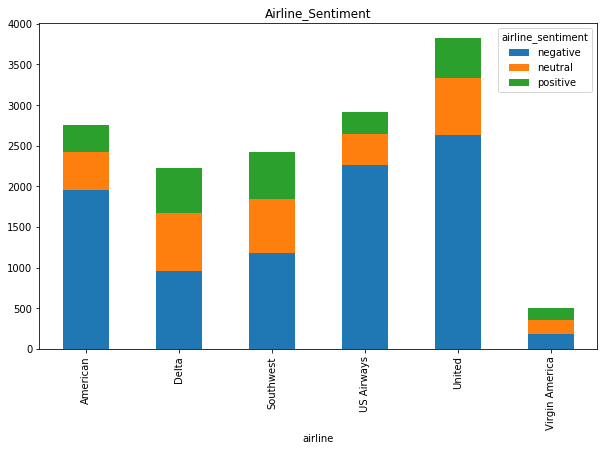

In [0]:
airlinesentiment.plot(kind='bar',figsize=(10, 6),stacked=True,title="Airline_Sentiment")

 **Data  Cleaning**

Data cleaning is performed on the dataset by removing the punctuations.  I tried changing all words to lower case and removing stopwords but it did not help in enhancing the accuracy. Also, it can be seen only two variables from data is useful that is airline_sentiment and text columns

In [0]:
def remove(text):
  text_out=''.join([char for char in text if char not in string.punctuation])
  return text_out

# Taking only airline_sentiment and text columns for further analysis as these variables help in predicting the sentiments 
# This two columns are required for further analysis as can be concluded from above data visualizations

datacsv = df[['airline_sentiment', 'text']]

#datacsv['text'] = datacsv['text'].apply(lambda x: x.lower())
datacsv['text'] = datacsv['text'].apply((lambda x: remove(x)))

datacsv.to_csv('tweetsData.csv',index=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


**Splitting the data into train and test datasets**

In [0]:

#Splitting the data into 80% train and 20% test and using stratify to maintain the same proportion of the categorical target variable in the data partitions in order to improve the accuracy


dfTrain, dfTest = train_test_split(datacsv, stratify=datacsv[['airline_sentiment']],test_size = 0.2, random_state = 123)

#Converting the training and testing data samples into csv

dfTrain.to_csv('tweetsTrain.csv', index=False)
dfTest.to_csv('tweetsTest.csv', index=False)



print("Number of entries in training data: ",len(dfTrain))
print("Number of entries in testing data: ",len(dfTest))
print("Shape of the samples in training dataset: " ,dfTrain.shape)
print("Shape of the samples in testing dataset: " ,dfTest.shape)

Number of entries in training data:  11712
Number of entries in testing data:  2928
Shape of the samples in training dataset:  (11712, 2)
Shape of the samples in testing dataset:  (2928, 2)


**Data Preprocessing** 

**Tokenization**
The first step in pre-processing is Tokenization which means to split the raw sentences to words or tokens


*   Take care of spaces
*   Take care of Capital letters and add a special token for them


In [0]:
path=''
data = TextClasDataBunch.from_csv(path, 'tweetsTrain.csv')
data.show_batch()

text,target
xxbos usairways xxup fuk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup overpriced xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup fuk u xxup and,negative
xxbos southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp xxmaj like u xxmaj in xxmaj future,positive
xxbos united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxup best xxup day xxup ever xxup thank u xxup so xxup much,positive
xxbos united xxmaj she 👏 wo nt 👏 be 👏 at 👏 my 👏 wedding 👏 xxmaj this is an xxunk xxunk xxmaj there s no reflight xxmaj booking xxmaj problems xxmaj how can we be xxunk for this,negative
xxbos usairways not happy w app xxmaj late xxmaj flightly xxmaj last time i flew would nt let me check in xxmaj this time i checked in went on xxmaj late xxmaj flightr says i never checked in,negative


As observed above the words are split on space. The special tokens (starting with xx) which replaces the unknown token are further converted to integers in Numericalization. Normally the special tokens are replacing the words written in capital form. This balances capturing semantic meaning with reducing the number of overall tokens — so it is both powerful and efficient.

**Numericalization**

After extracting tokens, we convert it to integers by creating a llist of all the words used in the data The correspondance from ids to tokens is stored in the vocab attribute in itos dictionary (for int to string).

In [0]:
#Visualizing the tokens from the tokenized list
data.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'to',
 'i',
 'the',
 'a',
 'you',
 'united',
 'for',
 'flight',
 'on',
 'and',
 'my']

In [0]:
print(data.train_ds[0][0])
print(data.train_ds[1][0])
print(data.train_ds[2][0])

xxbos southwestair xxmaj your xxmaj terry is our hero xxmaj got my husband back thru security to retrieve his cellphone in xxmaj austin xxmaj terry 85832 xxmaj you xxmaj rock
xxbos americanair xxmaj we ve 15 official complaints signed by americanairlines xxmaj lima supervisor xxmaj customer xxmaj relations pls compensate 4 the xxunk delay
xxbos united thanks for having no one to pilot my last two flights and all but stranding me in xxmaj houston tonight xxmaj airlines are the absolute worst


In [0]:
#converting the words to integers
print(data.train_ds[0][0].data[:10])
print(data.train_ds[1][0].data[:10])
print(data.train_ds[2][0].data[:10])

[   2   24    5   33    5 2360   22   63 2815    5]
[   2   21    5   46  100  327 1686  847 2082  112]
[  2  14  47  15 371  37  83   9 328  19]


The tokenization and numericalization is done by the TextLMDataBunch and TextClassDataBunch from fastai package respectively internally. The tokenization of fastai captures semantic menaing from the data. It does not change the words to lowercase or removes stopwords(which is seen till now). This is because it would result in loss of data and would not help the model to understand the new task's vocabulary

**Method:** Universal Language Model Fine-tuning for Text Classification or ULMFiT model. ULMFiT utilizes LSTM which is the state-of-the-art language model architecture (AWD-LSTM).

There are three stages in ULMFiT model are for Transfer Learning–



*   General domain language model pre-training
*   Target task language model fine-tuning

*   Target task classifier fine-tuning

Mainly, the objective here is to fine tune a pre-trained model and use (or transfer) it for text classification task for new dataset (in this case Tweets.csv)

**General domain language model pre-training**

In [0]:
#Language model data using the training sample csv 
path=''

#Fetching data for training the language model from csv and increasing the bacth size from my last submission in order to improve accuracy
data_lm = TextLMDataBunch.from_csv(path, 'tweetsTrain.csv', bs=128)


#If we want to save the text bunch to a file at the given path so that, next time data bunch process does not take much time
data_lm.save('data_lm.pkl')
data_lm=load_data(path,'data_lm.pkl')
data_lm.show_batch()

idx,text
0,i m on standby for my connecting flight 1st on the list xxunk i m told there are four slots open xxmaj save it for me xxmaj please xxbos usairways yesterday we were delayed for xxup six hours xxunk to xxup no explanation we paid xxup lots of 2 fly wu amp this is how u treat ur customers xxbos usairways i was completely ripped of by xxup us xxmaj
1,xxmaj charlotte was xxmaj cancelled xxmaj flightled xxmaj now 5534 is on 1hr delay xxbos united i was sincerely xxunk the pilot of flight xxunk of xxunk the snow and getting me home amongst many other xxmaj cancelled xxmaj flightlations xxbos southwestair no thanks i think we have it straight xxbos usairways xxunk my patience this evening or shall i say morning xxmaj we waited an hour at the gate
2,xxunk since my xxunk from xxup dca to xxup msy was xxmaj cancelled xxmaj flightled still trying to get out xxmaj on hold now 50min xxrep 4 s xxbos americanair xxmaj ok xxmaj we will probably xxmaj cancelled xxmaj flight our flights then take a refund and get home another way xxmaj wednesday wo nt work for us xxbos jetblue thx for confirming xxmaj again yr team is awesome xxmaj
3,fly xxmaj southwest to xxmaj vegas 😩 😭 xxbos southwestair from xxup lga to xxmaj san xxmaj diego xxbos americanair no vouchers 4 xxmaj cancelled xxmaj flighted flight due 2 weather xxmaj todays issue broken tire xxmaj no vouchers cause tire was broken by weather xxunk xxbos jetblue the amount of money i spent on hotels for a xxup week bc of flight xxmaj cancelled xxmaj flightlation another flight does
4,usairways xxmaj mad love httptco4ojrsdwpkk xxup nyc xxbos americanair v nice of you to give me a breakfast voucher for 7 in an airport xxmaj that almost got me a whole drink xxbos jetblue i will try that xxmaj thanks xxmaj if all else fails i will just do the old xxunk method tomorrow morning xxbos americanair xxunk xxmaj if you updated the screens then people would know the xxmaj


The pre-processing is done for the dataset internally when we use TextLMDataBunch module from fastai package. This data pre-processing which is done iternally can be shown as follows:

In [0]:
x,y = next(iter(data_lm.train_dl))
example = x[:15,:15].cpu()
texts = pd.DataFrame([data_lm.train_ds.vocab.textify(l).split(' ') for l in example])
texts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,airways,today,never,fly,this,airline,i,am,contacting,my,local,news,xxbos,americanair,spent
1,for,you,to,find,a,gate,agent,xxunk,xxbos,united,the,passengers,waited,inside,the
2,thanks,for,the,prompt,amp,helpful,response,xxmaj,cheers,to,less,snow,in,everyones,future
3,nt,make,up,for,the,money,lost,xxbos,xxup,lmao,“,jetblue,xxmaj,our,fleets
4,late,xxmaj,flightst,info,good,or,bad,xxmaj,and,that,would,nt,work,because,xxbos
5,even,get,on,xxunk,you,help,me,xxbos,usairways,merging,with,xxmaj,american,will,xxunk
6,xxunk,xxbos,americanair,flight,veers,off,icy,runway,at,dfwairport,xxmaj,most,xxup,dfw,flights
7,just,spoke,with,a,representative,xxmaj,moved,my,flight,earlier,xxmaj,thank,you,so,much
8,xxbos,usairways,not,impressed,with,your,customer,service,everyone,has,been,unhelpful,and,incredibly,rude
9,xxmaj,decisions,xxunk,united,xxmaj,we,d,love,for,you,to,try,our,service,xxmaj


This pre-processed data is then passed to the Language Model to train the model. The model is not trained from scratch with the sentiments and texts of this dataset but use a pretrained model on bigger dataset(wikitext-103). That model has been trained to guess what the next word will be as all the previous words are its input. It has a recurrent structure and a hidden state which when sees a new word, gets updated everytime.

**Target task language model fine-tuning**

As the English of the reviews left by people on tweets would not be similar to English of wikipedia, there needs adjustment in the parameters of pre-trained model. Also, some slang words and language words which would not be a part of wikipedia could be a part of tweets so the vocab the model was trained would not be entirely same. So, Fine-Tuning of the parameters of pre-trained model needs to be done to get efficient results on our dataset

In [0]:
#Taking AWD_LSTM for the pretrained model and using the data obtained from the TextLMDataBunch to fine tune the learner
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

**Find the optimum learning rate for the model**

The objective is that the optimization function needs to use a learning rate that is at least an order of magnitude below the point at which the loss starts to diverge.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 6.31E-02


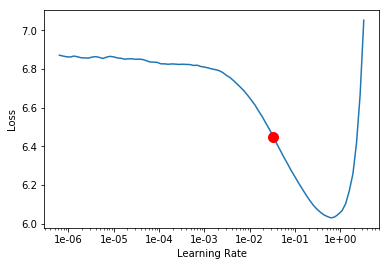

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:

# Fitting the model without unfreezing any layers
learn.fit_one_cycle(1,1e-3, wd = 1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,6.480605,6.109169,0.130114,00:16


In [0]:
#Unfreezing the last layer of model
learn.freeze_to(-1) 
learn.fit_one_cycle(1,1e-3, wd = 1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,6.009564,5.685253,0.140889,00:16


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


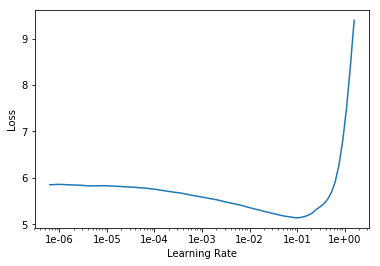

In [0]:
#Unfreezing all the layers of the model 
learn.unfreeze()


# To find optimal learning rate after unfreezing the layers of model
learn.lr_find()
learn.recorder.plot()

**Discriminative Fine-Tuning**
As AWD_LSTM consists of three layers, it is capable of capturing different types of information at every level, starting with general information on the first one and growing more and more specific on every further layer.
In the textual data context, the first layer might catch information like basic sentence structure, while the next ones dig deeper, such as the workings of different tenses.

Starting with a small LR in the first LSTM, it increases through the layers due to the increasing amount of acquired knowledge and information complexity. Here, a numpy array is defined which exponentially increases LRs, starting with the smallest one for the first LSTM.

In [0]:
#Optimal learning rate which can be observed above
lr  = 1e-2

# set discriminative learning rate
dlr= 2.6

#Defining a numpy array for the different layers starting with small value and then exponentially increasing
olr = np.array([lr/(dlr**3), lr/(dlr**2), lr/dlr, lr])

#fit with one cycle length, 3 epochs and weight decay 1e-7
learn.fit_one_cycle(3,olr,wd=1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,4.744658,4.114628,0.232366,00:21
1,4.178636,3.944410,0.248661,00:21
2,3.736148,3.939382,0.251055,00:21


In [0]:
# Saving learner for further training, analysis and to load the weights
learn.save('languagemodel')
# Saving encoder for further analysis
learn.save_encoder('fine_tune_enc')


In [0]:
# To evaluate the model so far
# We will  give a model a set of words to see what it learned from the data and print 5 lines of 30 words having those words
for i in range (3):
  print(learn.predict('Terrible Airline',n_words=30))

Terrible Airline Ever xxbos americanair Waiting for a gate to be delivered to Dallas She prepared 6 hours for the flight Date of 1 am 😥 yeah
Terrible Airline xxbos usairways Doubt it to be 70 chance to get stand by seat on a domestic flight Have usairways DM when am i really in touch with
Terrible Airline cont Our a Day RDU travels with you many other delays that i should be ashamed xxbos jetblue Flight flightno tomorrow to GRR Dfw


**Target Task Classifier**

Here we create data for classifier model which does all the preprocessing needed for text classification analysis. The vocab module is used for mapping ids to words and also ensures that data_clas uses the same dictionary as data_lm as seen in the data pre-processing part of code

This step defines that our model can predict a class label once we re-train the model as a classifier

In [0]:
# Data for Classifier model and training the model with labels

data_clas = TextClasDataBunch.from_csv(path, 'tweetsTrain.csv', vocab=data_lm.train_ds.vocab, bs=128)

#If we want to save the text classification bunch to a file at the given path so that, next time data bunch process does not take much time
data_clas.save('data_clas.pkl')
data_clas=load_data(path,'data_clas.pkl')
data_clas.show_batch()

text,target
xxbos usairways xxup fuk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup overpriced xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup fuk u xxup and,negative
xxbos usairways xxup plans xxup changed xxup is xxup that xxup what u xxup call xxup not xxup bein xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection seriously,negative
xxbos united xxup where xxup is xxup my xxup fucking xxup bag xxmaj where the fuck is my fucking bag xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human xxup xxunk m,negative
xxbos united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxup best xxup day xxup ever xxup thank u xxup so xxup much,positive
xxbos united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card 150 xxup starbucks xxup card i xxup handed xxup over,negative


The pre-processed data with numericalization done is seen as below:

In [0]:
iter_dl = iter(data_clas.train_dl)
_ = next(iter_dl)
x,y = next(iter_dl)
x[-10:,:20]

tensor([[   1,    2,   24,   90,    7,  110, 1487,   10,   38,   26,  159,  412,
          590,    9, 3146,   68,  688, 1211],
        [   1,    2,   25,   76,   13,   15, 1600,   61, 1063,   42,   86,    9,
           16,    5, 1232,  212,   22, 3529],
        [   1,    2,   24,  394,  119,   38,   13,   31,   12, 2259, 4126,  186,
          632,   81,    5,   47,    5, 1800],
        [   1,    2,   93, 3367, 3368,    5,   98,  144,  264,    0,    0,    5,
         2855, 3367,   10,  257, 3368, 2100],
        [   1,    2,   24,   28,  899,  466,   30,  839,  214, 1285,   46, 1681,
          837,  360,  295,   23,   18,  601],
        [   1,    2,   24,    5,  239,   38,   30,    5,   82,   26,    6,  166,
          339,   13,  294,   29,    5,   47],
        [   1,    2,   25,    5,   77, 1033,    0,   37,    6,    0,   17,   12,
            5,  631,   37,    6,  233, 1587],
        [   1,    2,   24,   76,   13,   15,  356,  140, 1106,   18,  716,   35,
           33,   61,   51,    

In [0]:
#Training the model using classifier data 
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)

#loading the saved language encoder
learn.load_encoder('fine_tune_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 3.02E-02


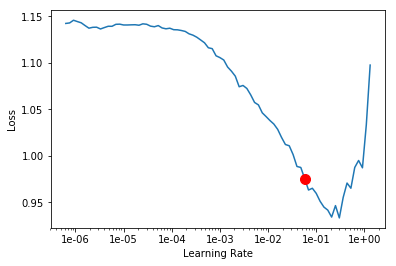

In [0]:
# To find the optimal learning rate after the model has been trained with classifier
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
#Optimal learning rate which can be observed above
lr  = 3e-3

# set discriminative learning rate
dlr = 2.6

#Defining a numpy array for the different layers starting with small value and then exponentially increasing
olr = np.array([lr/(dlr**4), lr/(dlr**3), lr/(dlr**2), lr/dlr, lr])

**Gradual Unfreezing:**

The aggressive fine-tuning pf the target classifier may lead to removing the benefits of language model pre-training and so we need to fine tune  and unfreeze the layers of model gradually: 

*   The last LSTM layer is first unfrozen and the model is fine-tuned with one epoch
*   Then the next last layer is unfrozen

*   This process is repeated until we get all layers fine tuned to convergence





In [0]:
#Fitting into the model for 1 epoch and weight decay 1e-7
learn.fit_one_cycle(1,olr, wd = 1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,0.670704,0.560438,0.781477,00:09


In [0]:
#Unfreezing the last two layers of model
learn.freeze_to(-2)
learn.fit_one_cycle(1,olr, wd= 1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,0.601862,0.511149,0.794708,00:12


In [0]:
#Unfreezing all the layers of model and fine tuning it
learn.unfreeze()
learn.fit_one_cycle(5,olr, wd=1e-7)


epoch,train_loss,valid_loss,accuracy,time
0,0.543556,0.503359,0.790440,00:23
1,0.486880,0.471701,0.820743,00:24
2,0.381273,0.502591,0.822023,00:24
3,0.250449,0.538461,0.821169,00:25
4,0.174795,0.577526,0.829279,00:26


In [0]:
# predict the sentiment for testing data from the model obtained and calculate accuracy
import warnings
warnings.simplefilter('ignore')
dfTest['pred_sentiment'] = dfTest['text'].apply(lambda row: str(learn.predict(row)[0]))
dfTest

,airline_sentiment,text,pred_sentiment
3047,negative,united abigailedge Another glitch,negative
5991,neutral,SouthwestAir I got a phishing email claiming t...,neutral
12793,negative,AmericanAir Why doesnt anyone make a better ef...,negative
7317,positive,JetBlue thanks for the quick response Fingers ...,positive
4883,neutral,SouthwestAir is service to Aruba being permane...,neutral
8779,negative,JetBlue where exactly can I leave a note,neutral
13875,negative,AmericanAir seriously I do not want to wait 24...,negative
11648,negative,USAirways I have a voucher from a past trip th...,negative
4154,neutral,united The guidelines say 10x9x17 my bag is 20...,negative
2284,negative,united FlightUA1750 is basically a prison on t...,negative


In [0]:
#Accuracy of model on the test data
from sklearn.metrics import confusion_matrix, accuracy_score
print("Test Accuracy: ", accuracy_score(dfTest['airline_sentiment'], dfTest['pred_sentiment']))

Test Accuracy:  0.826844262295082


**Testing the model on some Random Tweets**

In [0]:
learn.predict("@delta flight experince with you was okay not that up to the mark")

(Category neutral, tensor(1), tensor([0.1040, 0.8586, 0.0375]))

In [0]:
learn.predict("The service of Spirt Airways needs improvement!")

(Category negative, tensor(0), tensor([0.9427, 0.0440, 0.0133]))

In [0]:
learn.predict("The food of Delta was good but overall experience was not nice")

(Category negative, tensor(0), tensor([9.9749e-01, 2.5338e-04, 2.2564e-03]))

In [0]:
learn.predict("THANK YOUUU! @AirFrance for grreaat flight experience. I would recommend this")

(Category positive, tensor(2), tensor([0.0013, 0.4368, 0.5618]))

ULMFiT was chosen because compared to other techniques the testing accuracy was high as can be seen below:



*   Random Forest= 75%
*    AdaBoost= 72%

*   Multinomial Logistic Regression= 65%

*   Deep Learning Model with Dropouts in Keras - 77.9%

*    **Results with ULMFiT model : Training=82.93% and Testing=82.68%**



These results show that building the model from scratch for small datasets may not give efficient accuracy but, transfer learning that is fine-tuning the pre-trained model on complex dataset using our dataset even if it is small in size provides efficient results. 

The results shows that ULMFiT provides state-of-the-art (SOTA) results even with a dataset as small as Twitter US Airline Sentiment. Also, difference between source and target domain does not appear to affect the performance.









**The accuracy can be further enhanced by fine tuning the parameters for example by showing momentums by plot_lr(show_moms=True) and using the optimal momentum range for fine-tuning and fitting the model. I tried using this experiment and got around 83% but it was varying everytime and went down to 80%  sometimes so, was not able to get stable results. I was getting stable results using this method of an array with exponentially increasing weights. So, I opted to use this method**


Normal data pre-processing  and cleaning techniques like chaning the words to lower case, or removing stopwords and so on does not help for this problem because much information will be lost and this will not help the pre-trianed model understand the semantic meaning of new datasets.However, removing the punctuations as a part of data cleaning helped in increasing the accuracy. These informations are required to be learned to understand the patterns and variations. But, conversion needs to be done from string encoded to vector of integers which is done using TextLMDataBunch(Toeknization) and TextClassDataBunch(Numericalization) from fastai package

**Compared to my earlier submission, I tried using numpy array of exponentially increasing values for fine-tuning the model, I increased the batch size, as a part of data cleaning I removed punctuations and also used weight decay to enhance results. By performing all these changes it helped me to increase my training and testing accuracy from 79% to 83% In addition to this, further fine tuning the model may help in achieving even higher accuracy**. 